In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `~/git/Veritasium-SciComm-Contest/Project.toml`


In [2]:
using MeshCat
using MeshCatMechanisms
using Plots
using RigidBodyDynamics
using RigidBodySim

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-10853272036641424062\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-1588814522691663321\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-10853272036641424062\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

# Start the visualisation

In [3]:
vis = Visualizer()
MeshCat.setprop!(vis["/Cameras/default/rotated/<object>"], "fov", 30)
IJuliaCell(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://localhost:8700
└ @ MeshCat /home/henrique/.julia/packages/MeshCat/X2AUA/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Cameras" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("default" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rotated" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("fov" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x64, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8700))

# Load the pendulum

In [4]:
gravity_zero = [0, 0, 0]  # Space
gravity_earth = [0, 0, -9.81]  # Earth
gravity_saturn = [0, 0, -11.17]  # Saturn

urdfpath = joinpath(@__DIR__, "mechanism.urdf")
mechanism = parse_urdf(urdfpath, gravity = gravity_earth)  # you can change gravity here
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdfpath), vis[:robot])
state = MechanismState(mechanism);

# Initial conditions

In [5]:
zero!(state)  # Reset positions and velocities to zero

set_configuration!(state, [0, 0.9π])  # Set position
# set_velocity!(state, [0, 4.5])      # Set velocity

set_configuration!(mvis, configuration(state))  # Update visualisation

# Simulate system

In [6]:
tₛ, tₜ = 0.0, 4.0  # simulation duration
dt = 1 / 1000       # controller @ 1 kHz

tspan = (tₛ, tₜ)
history_q = Matrix{Float64}(undef, 2, 0)

function control!(τ::AbstractVector, t, state::MechanismState)
    global history_q
    history_q = [history_q copy(configuration(state))]

    q₁ = configuration(state)[1]
    v₁ = velocity(state)[1]

    q⁺ = 0.01 * sin(50 * 2π * t)  # desired position (50 Hz sine wave with 1 cm amplitude)
    v⁺ = π * cos(50 * 2π * t)  # desired velocity (first derivative of desired position)

    k_p, k_d = 5000, 50  # PD control gains

    τ[1] = k_p * (q⁺ - q₁) + k_d * (v⁺ - v₁)  # PD controller output (proxy of a jig saw)
    τ[2] = 0.005 * (0 - velocity(state)[2])  # account for very small friction of the ball bearing
end

controller = PeriodicController(similar(velocity(state)), dt, control!)
dynamics = Dynamics(mechanism, controller)
# dynamics = Dynamics(mechanism, zero_control!)
ode_problem = ODEProblem(dynamics, state, tspan)
sol = solve(ode_problem, Tsit5())
setanimation!(mvis, sol)

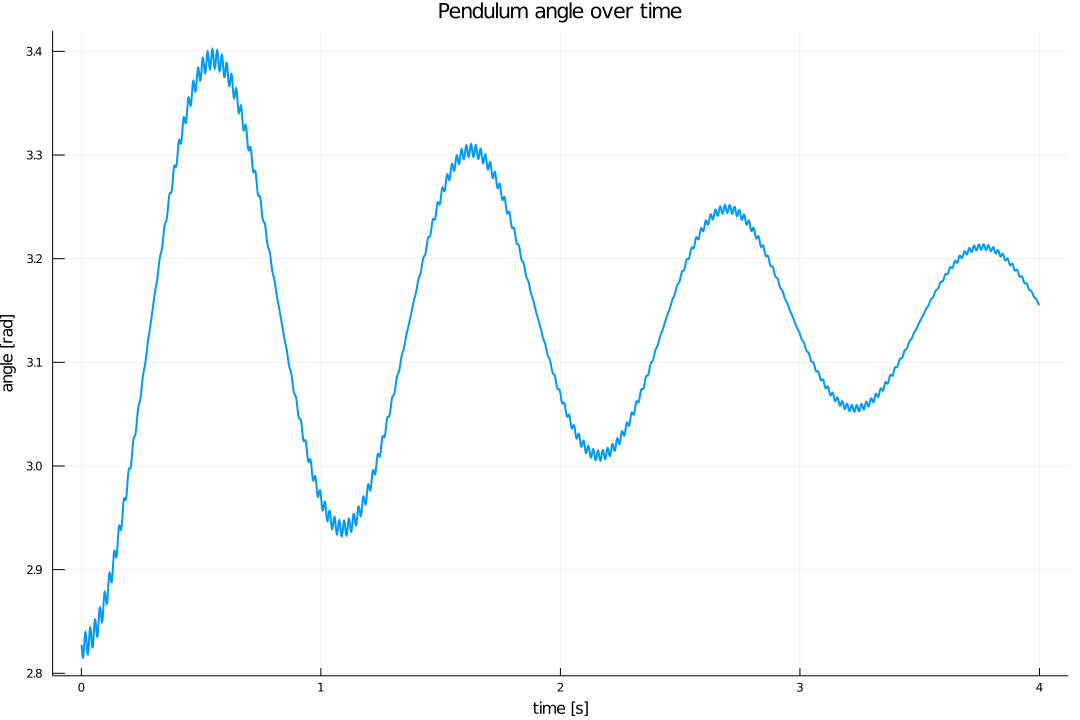

In [7]:
plot(
    range(0, tₜ, step=dt), history_q[2,:],
    title="Pendulum angle over time", legend=nothing,
    xlabel="time [s]", ylabel="angle [rad]",
    size=(1080, 720), linewidth=2,
)